In [1]:
!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu117


In [2]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## I. MNIST Data

### Exercice 1 : Loading Data

In [3]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [4]:
def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
    assert(nb_nodes > 0 and nb_nodes <= 10)

    total_samples = len(dataset)

    samples_per_node = total_samples // nb_nodes

    dataloader = DataLoader(dataset, batch_size=total_samples, shuffle=shuffle)
    dataiter = iter(dataloader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted = []

    for i in range(nb_nodes):
        start_idx = i * samples_per_node
        end_idx = (i + 1) * samples_per_node

        node_images = images_train_mnist[start_idx:end_idx]
        node_labels = labels_train_mnist[start_idx:end_idx]

        node_dataset = torch.utils.data.TensorDataset(node_images, node_labels)

        node_loader = DataLoader(node_dataset, batch_size=batch_size, shuffle=shuffle)
        data_splitted.append(node_loader)

    return data_splitted

2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [5]:
import torch
from torch.utils.data import DataLoader

def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes > 0 and nb_nodes <= 10)

    digits = torch.arange(10) if not shuffle_digits else torch.randperm(10)

    digits_split = torch.chunk(digits, nb_nodes)

    loader = DataLoader(dataset,
                        batch_size=nb_nodes*n_samples_per_node,
                        shuffle=shuffle)
    dataiter = iter(loader)
    images_train, labels_train = next(dataiter)

    data_splitted = []
    for i in range(nb_nodes):
        mask = torch.tensor([label.item() in digits_split[i] for label in labels_train])

        images_train_node = images_train[mask]
        labels_train_node = labels_train[mask]

        node_dataset = list(zip(images_train_node, labels_train_node))
        loader_node = DataLoader(node_dataset, batch_size=batch_size, shuffle=shuffle)

        data_splitted.append(loader_node)
    
    return data_splitted

3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [6]:
import torchvision
from torchvision import transforms

def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    if type == "iid":
        train_loaders = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_loaders = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    else:
        raise ValueError("Invalid 'type' parameter. Use 'iid' or 'non_iid'.")

    return train_loaders, test_loaders

4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [7]:
mnist_iid_train, mnist_iid_test = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

In [8]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    #if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

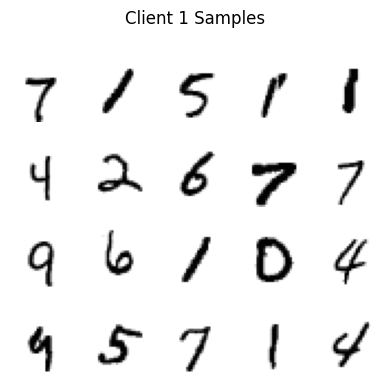

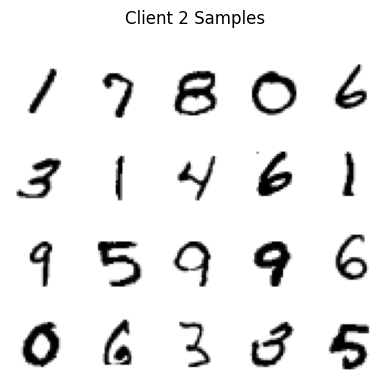

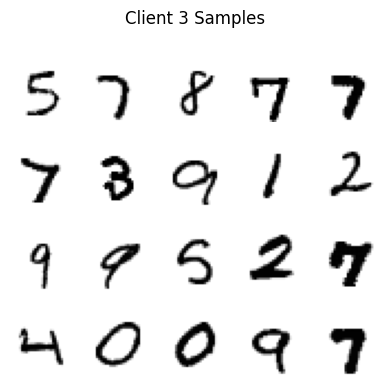

In [9]:
import matplotlib.pyplot as plt

def get_client_samples(client_id):
    client_data_loader = mnist_iid_train[client_id]
    dataiter = iter(client_data_loader)
    images, labels = next(dataiter)
    return images, labels

client_1_images, client_1_labels = get_client_samples(0)
plot_samples((client_1_images, client_1_labels), channel=0, title="Client 1 Samples", plot_name="client_1_samples")

client_2_images, client_2_labels = get_client_samples(1)
plot_samples((client_2_images, client_2_labels), channel=0, title="Client 2 Samples", plot_name="client_2_samples")

client_3_images, client_3_labels = get_client_samples(2)
plot_samples((client_3_images, client_3_labels), channel=0, title="Client 3 Samples", plot_name="client_3_samples")

plt.show()

6) Plot samples this time for non_iid data for 3 clients.

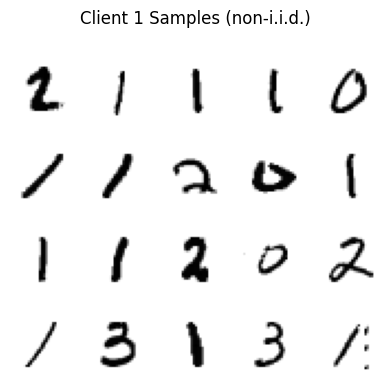

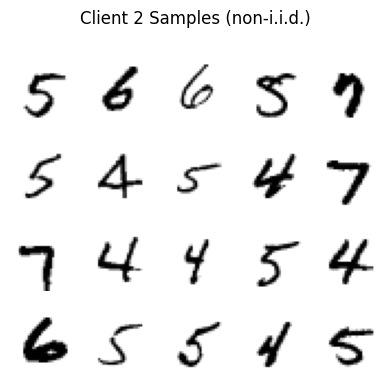

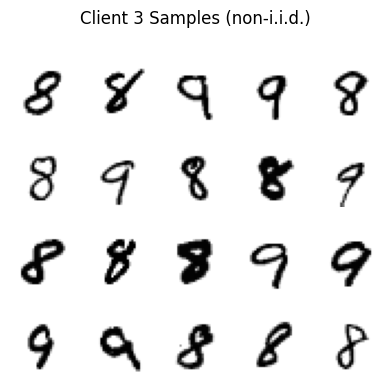

In [10]:
import matplotlib.pyplot as plt

non_iid_train, non_iid_test = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

def get_client_samples(client_id):
    client_data_loader = non_iid_train[client_id]
    dataiter = iter(client_data_loader)
    images, labels = next(dataiter)
    return images, labels

client_1_images, client_1_labels = get_client_samples(0)
plot_samples((client_1_images, client_1_labels), channel=0, title="Client 1 Samples (non-i.i.d.)", plot_name="client_1_samples_non_iid")

client_2_images, client_2_labels = get_client_samples(1)
plot_samples((client_2_images, client_2_labels), channel=0, title="Client 2 Samples (non-i.i.d.)", plot_name="client_2_samples_non_iid")

client_3_images, client_3_labels = get_client_samples(2)
plot_samples((client_3_images, client_3_labels), channel=0, title="Client 3 Samples (non-i.i.d.)", plot_name="client_3_samples_non_iid")

plt.show()

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [11]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.


In [12]:
def difference_models_norm_2(model_1, model_2):
    """Return the L2 norm of the parameter differences between two models."""
    sum_of_square_diff = 0.0

    # Iterate through the parameters of both models
    for param1, param2 in zip(model_1.parameters(), model_2.parameters()):
        if param1.requires_grad and param2.requires_grad:
            diff = param1 - param2
            sum_of_square_diff += torch.sum(diff**2)

    return sum_of_square_diff

Here is the function to perform one epoch of training data.

In [13]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [22]:
def local_learning(model, mu, optimizer, train_data, epochs, loss_f):
    model_copy = deepcopy(model)  # make a copy of the model

    for epoch in range(epochs):
        local_loss = train_step(model, model_copy, mu, optimizer, train_data, loss_f)

    return float(local_loss.detach().cpu().numpy())

We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [15]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [16]:
def average_models(model, clients_models_hist:list , weights:list):
    """Creates the new model of a given iteration with the models of the other
    clients"""

    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):

        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)

    return new_model

4) We will now code a function to perform FedProx.

In [20]:


def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0,
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f=loss_classifier

    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)


    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach())
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []


    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params=[]
        clients_models=[]
        clients_losses=[]

        for k in range(K):

            local_model = deepcopy(model)
            local_optimizer = optim.SGD(local_model.parameters(), lr=lr)  # Define your optimizer here
            local_loss = local_learning(local_model, mu, local_optimizer, training_sets[k], epochs, loss_f)

            clients_losses.append(local_loss)

            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))


        #CREATE THE NEW GLOBAL MODEL
        # Create new global model by avering all locals models
        model = average_models(model, clients_params, weights)
        models_hist.append(clients_models)

        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach())
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')


        server_hist.append([tens_param.detach().cpu().numpy()
            for tens_param in list(model.parameters())])

        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [23]:
# Perform FedAvg (FedProx with mu=0)
final_model, loss_hist, acc_hist = FedProx(
    model=model_0,
    training_sets=mnist_iid_train,
    testing_sets=mnist_iid_test,
    n_iter=10, 
    mu=0,
    epochs=2,
    lr=0.1,
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3058993816375732 Server Test Accuracy: 12.88128812881288
====> i: 1 Loss: 0.0419178990026315 Server Test Accuracy: 98.66986698669866
====> i: 2 Loss: 0.02125717761615912 Server Test Accuracy: 99.10991099109911
====> i: 3 Loss: 0.015114389359951018 Server Test Accuracy: 99.21992199219922
====> i: 4 Loss: 0.01055844376484553 Server Test Accuracy: 99.2199219921992
====> i: 5 Loss: 0.0076332072106500455 Server Test Accuracy: 99.28992899289928
====> i: 6 Loss: 0.005553057882934809 Server Test Accuracy: 99.34993499349935
====> i: 7 Loss: 0.004025209539880355 Server Test Accuracy: 99.34993499349935
====> i: 8 Loss: 0.0032281375024467702 Server Test Accuracy: 99.32993299329932
====> i: 9 Loss: 0.0024196944820384183 Server Test Accuracy: 99.36993699369937
====> i: 10 Loss: 0.0017198832938447595 Server Test Accuracy: 99.33993399339934


2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

In [24]:
def plot_accuracy_loss(title: str, loss_hist: list, acc_hist: list):

    num_clients = len(loss_hist[0])

    for i in range(num_clients):
        client_loss = [epoch[i] for epoch in loss_hist]
        client_acc = [epoch[i] for epoch in acc_hist]

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(client_loss, label=f'Client {i+1} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'{title} - Client {i+1} Loss')

        plt.subplot(1, 2, 2)
        plt.plot(client_acc, label=f'Client {i+1} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'{title} - Client {i+1} Accuracy')

        plt.show()

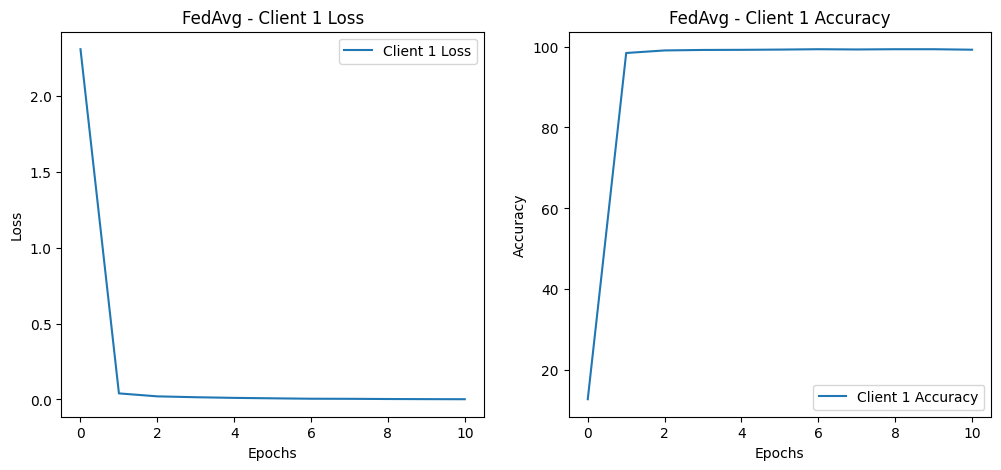

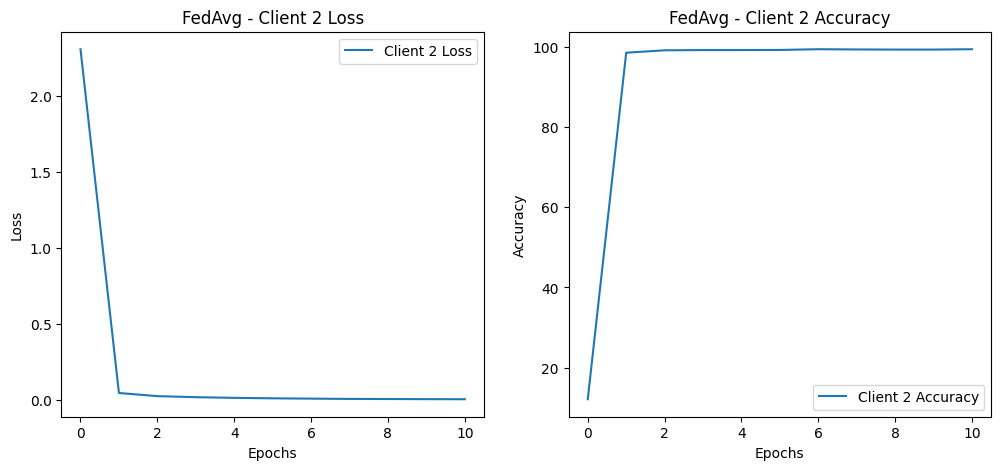

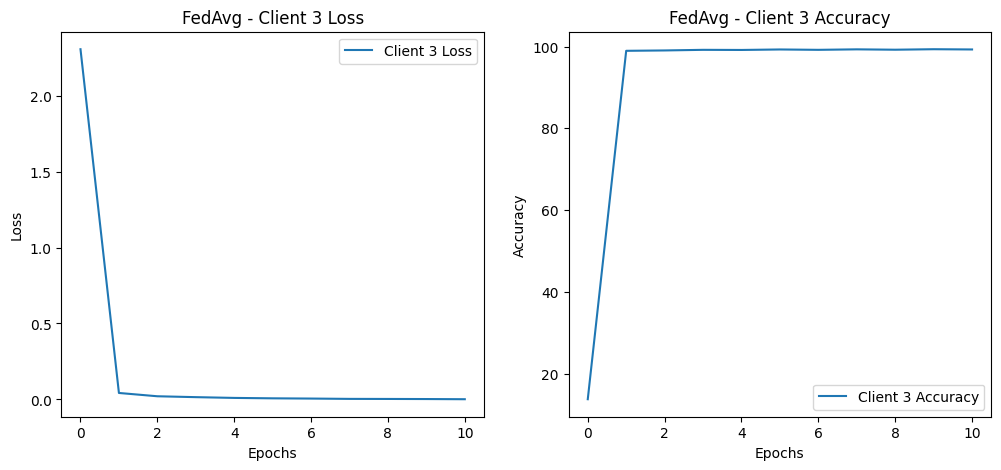

In [25]:
plot_accuracy_loss("FedAvg", loss_hist, acc_hist)

#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

In [27]:
final_model, loss_hist, acc_hist = FedProx(
    model=model_0,
    training_sets=mnist_iid_train,
    testing_sets=mnist_iid_test,
    n_iter=10,  # Number of iterations
    mu=0.3,  # Given mu value
    epochs=2,  # Number of local epochs
    lr=0.1  # Learning rate
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3058996995290117 Server Test Accuracy: 12.88128812881288
====> i: 1 Loss: 0.5345831513404846 Server Test Accuracy: 91.02910291029103
====> i: 2 Loss: 0.27259505788485205 Server Test Accuracy: 93.77937793779378
====> i: 3 Loss: 0.2220579981803894 Server Test Accuracy: 94.13941394139414
====> i: 4 Loss: 0.17616855601469675 Server Test Accuracy: 95.06950695069506
====> i: 5 Loss: 0.14995446304480234 Server Test Accuracy: 95.75957595759576
====> i: 6 Loss: 0.1277583340803782 Server Test Accuracy: 96.62966296629662
====> i: 7 Loss: 0.11454703658819197 Server Test Accuracy: 96.89968996899688
====> i: 8 Loss: 0.10912427554527918 Server Test Accuracy: 96.74967496749674
====> i: 9 Loss: 0.10630671928326288 Server Test Accuracy: 97.10971097109709
====> i: 10 Loss: 0.09785776336987813 Server Test Accuracy: 97.36973697369737


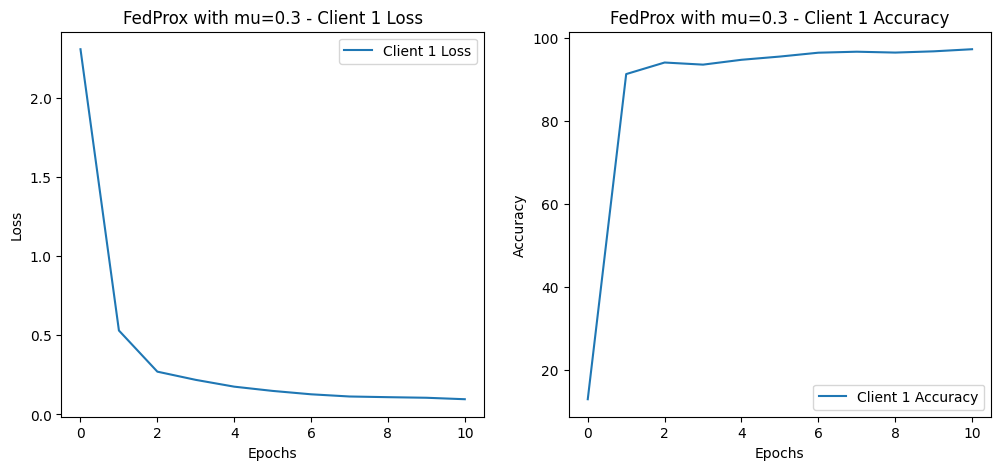

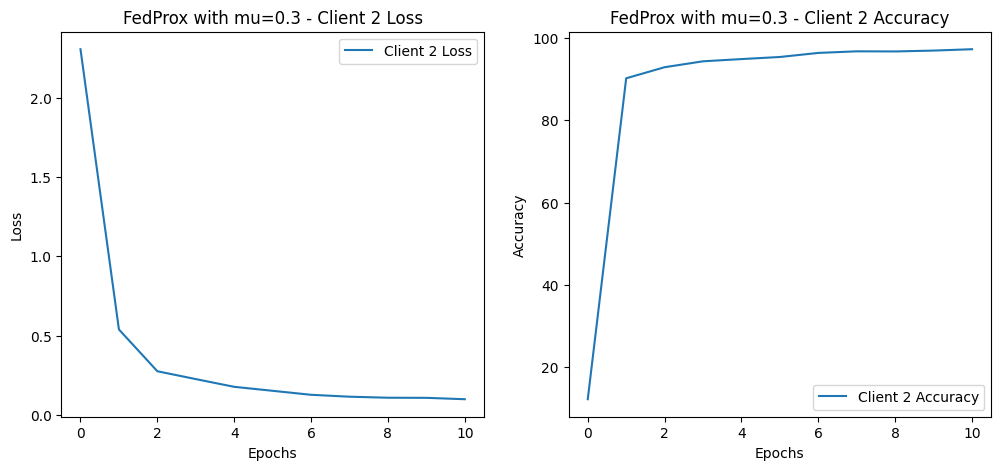

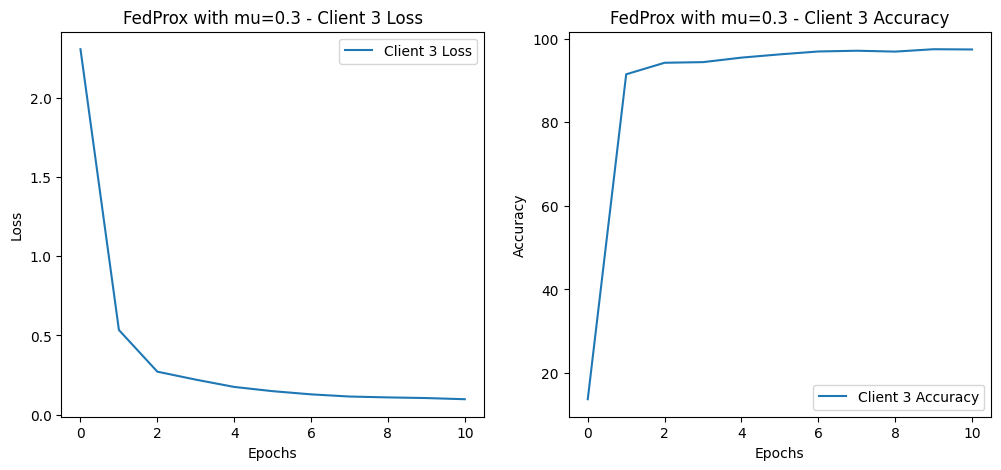

In [28]:
plot_accuracy_loss("FedProx with mu=0.3", loss_hist, acc_hist)

4) What do you observe ?

On observe que les accuracy évolue de façon simulaire, On a un fort potentiel d'overfitting mais surtout on peut remarqué que le FedProx et le FedAvg donne des résultats très similaire.

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.

In [29]:
final_model_avg, loss_hist_avg, acc_hist_avg = FedProx(
    model=model_0,
    training_sets=non_iid_train,
    testing_sets=non_iid_test,
    n_iter=10,  # Number of iterations
    mu=0,  # Setting mu to 0 for FedAvg
    epochs=2,  # Number of local epochs
    lr=0.1  # Learning rate
)

Clients' weights: [0.4166666666666667, 0.37833333333333335, 0.205]
====> i: 0 Loss: 2.3003941106796266 Server Test Accuracy: 13.88787370527307
====> i: 1 Loss: 2.258378790219625 Server Test Accuracy: 12.509136652542376
====> i: 2 Loss: 1.7485732909043632 Server Test Accuracy: 57.64384710451978
====> i: 3 Loss: 1.1607763317227364 Server Test Accuracy: 68.89009533898306
====> i: 4 Loss: 0.8009590807557105 Server Test Accuracy: 71.69131552102951
====> i: 5 Loss: 0.6143105738858382 Server Test Accuracy: 79.37318051632141
====> i: 6 Loss: 0.5570414086182913 Server Test Accuracy: 80.99904857187697
====> i: 7 Loss: 0.4654691080252329 Server Test Accuracy: 84.34179319679849
====> i: 8 Loss: 0.3419245285540819 Server Test Accuracy: 86.92254688480854
====> i: 9 Loss: 0.46120772406458854 Server Test Accuracy: 82.7112415646579
====> i: 10 Loss: 0.32640525509913765 Server Test Accuracy: 87.24806771814188


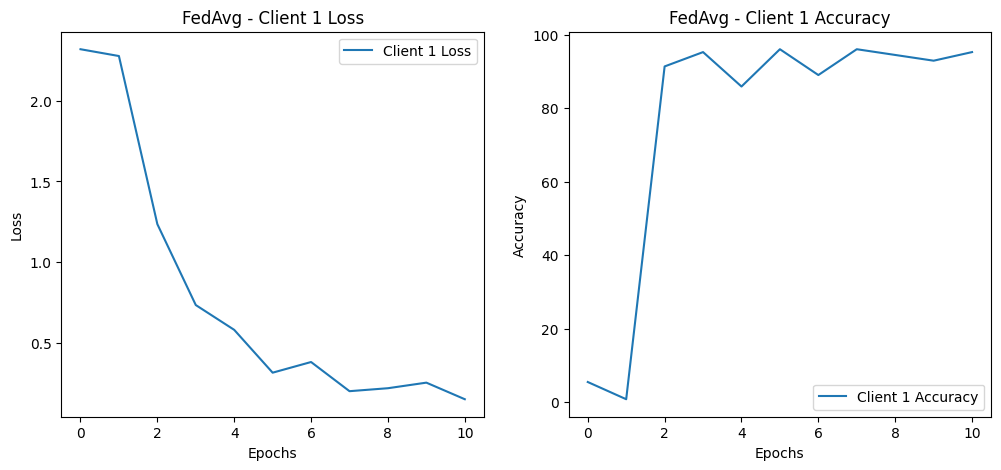

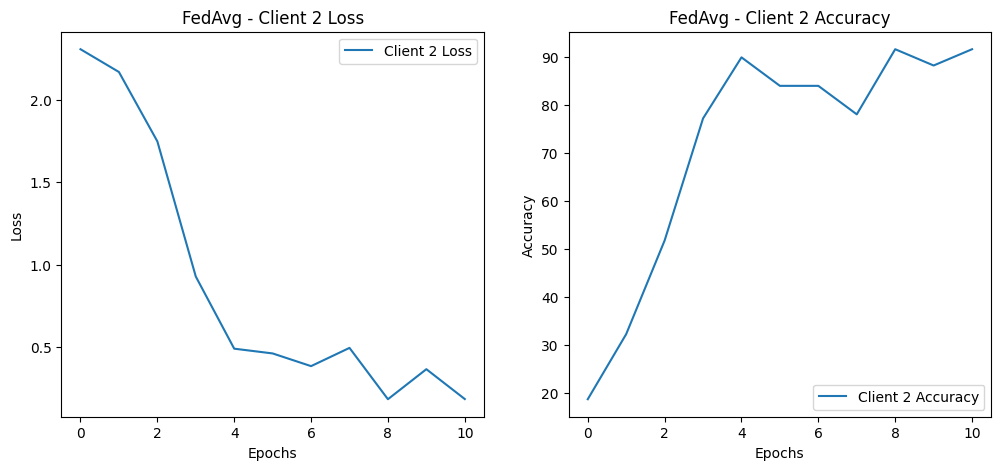

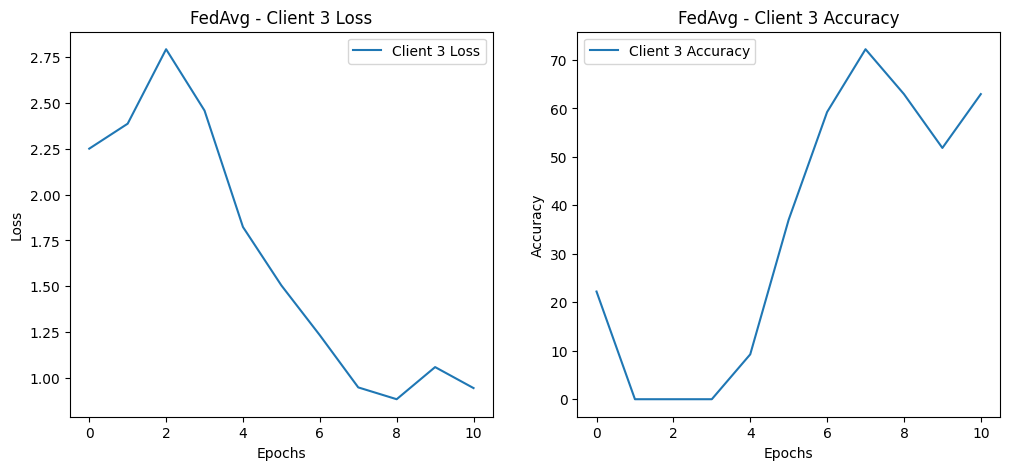

In [30]:
plot_accuracy_loss("FedAvg", loss_hist_avg, acc_hist_avg)

In [31]:
final_model_avg, loss_hist_avg, acc_hist_avg = FedProx(
    model=model_0,
    training_sets=non_iid_train,
    testing_sets=non_iid_test,
    n_iter=10,
    mu=0.3, 
    epochs=2,  
    lr=0.1  
)

Clients' weights: [0.4166666666666667, 0.37833333333333335, 0.205]
====> i: 0 Loss: 2.3009011725584667 Server Test Accuracy: 13.88787370527307
====> i: 1 Loss: 2.175637757778168 Server Test Accuracy: 16.070268361581924
====> i: 2 Loss: 2.3975098987420402 Server Test Accuracy: 11.221751412429379
====> i: 3 Loss: 1.3945919233560562 Server Test Accuracy: 55.37989936440678
====> i: 4 Loss: 1.1825330380598704 Server Test Accuracy: 56.37627510985562
====> i: 5 Loss: 0.6993221338589987 Server Test Accuracy: 79.05060714846202
====> i: 6 Loss: 0.6298556440075239 Server Test Accuracy: 82.71614092906465
====> i: 7 Loss: 0.48382046759128566 Server Test Accuracy: 87.74571366917765
====> i: 8 Loss: 0.39108879228432974 Server Test Accuracy: 89.056727675769
====> i: 9 Loss: 0.4584616135557493 Server Test Accuracy: 87.22357089610797
====> i: 10 Loss: 0.38250375861922903 Server Test Accuracy: 88.16965336629004


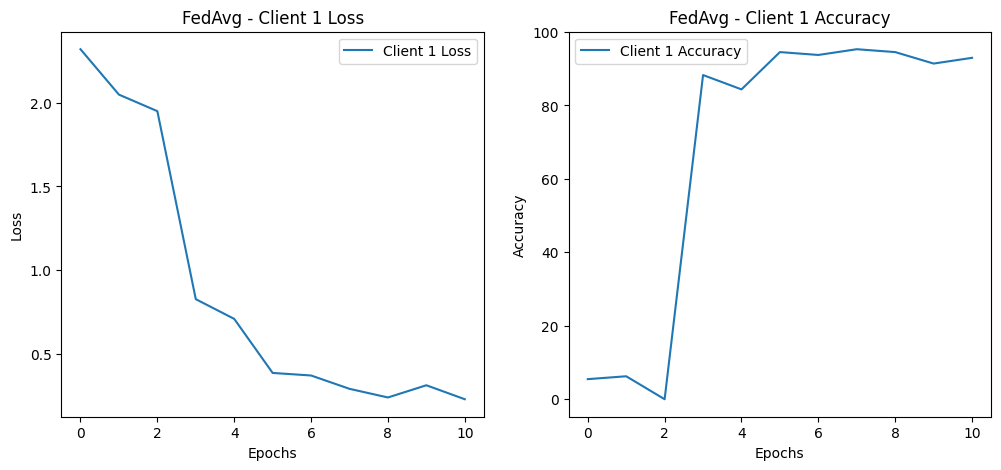

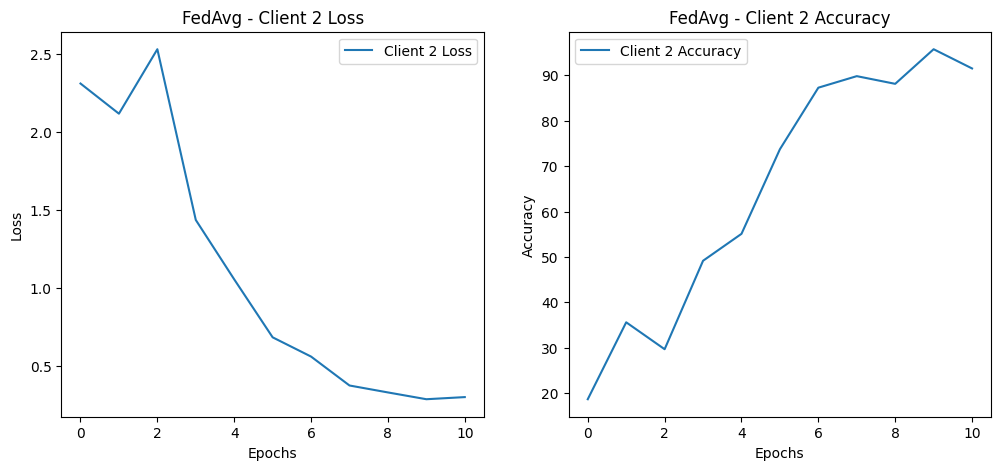

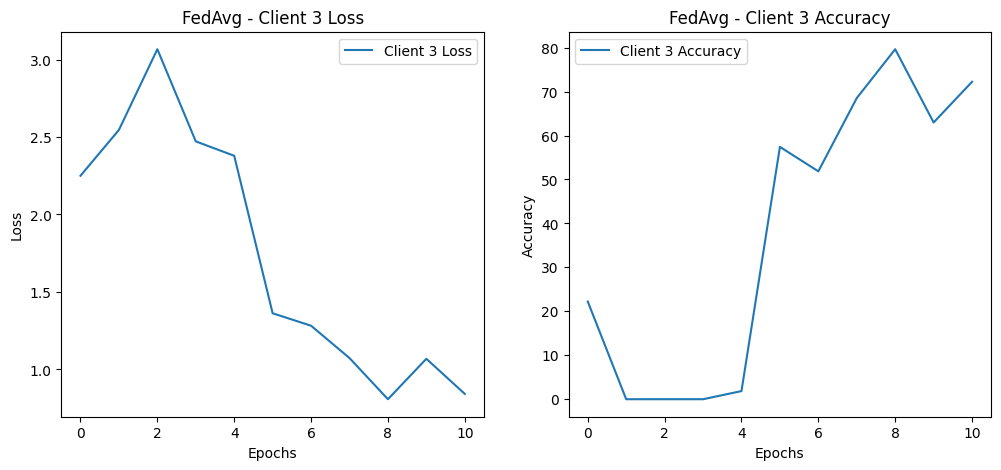

In [32]:
plot_accuracy_loss("FedAvg", loss_hist_avg, acc_hist_avg)

2) What do you observe ?

On peut voir que contrairement au iid data, On a une évolution moins stable de l'accuracy et une accuracy moins haute globalement. Et surtout chaque client a des accuracy différentes.

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [33]:
! pip install medmnist


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for medmnist from https://files.pythonhosted.org/packages/79/dc/82309525ccddfd9b6d33f37b12579addaa735747378231265f7a7847a4cc/medmnist-2.2.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116951 sha256=e10678999a2fc29e894e7b7ce32e0ecb64438f250e41253ac3cef671d254a74b
  Stored in directory: /home/amine/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


Import medmnist

In [34]:
import medmnist

You can list all available datasets with this command

We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [36]:
from medmnist import BloodMNIST

In [37]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [38]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [39]:
train_data = BloodMNIST(root='./data', split='train', transform=preprocess, download=True)
test_data = BloodMNIST(root='./data', split='test', transform=preprocess, download=True)



100%|██████████| 35461855/35461855 [00:18<00:00, 1931525.74it/s]


Using downloaded and verified file: ./data/bloodmnist.npz


4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

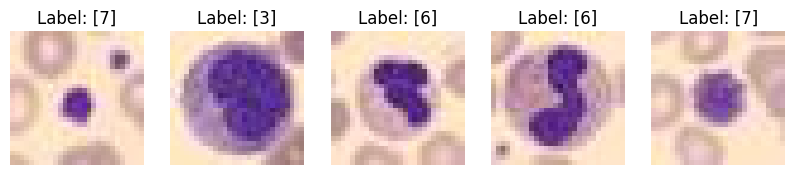

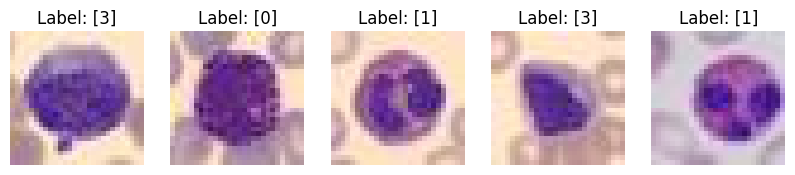

In [40]:
import matplotlib.pyplot as plt

def imshow(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 3))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.numpy().transpose((1, 2, 0)) 
        mean = 0.5
        std = 0.5
        img = std * img + mean 
        img = np.clip(img, 0, 1) 
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

imshow(train_data)

imshow(test_data)

5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [41]:
batch_size = 128
shuffle = True

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

In [42]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
    assert(nb_nodes > 0 and nb_nodes <= 8)  # Mise à jour du nombre de classes

    digits = torch.arange(8)  # Mise à jour du nombre de classes
    digits_split = torch.chunk(digits, nb_nodes)

    loader = DataLoader(dataset,
                        batch_size=nb_nodes * n_samples_per_node,
                        shuffle=shuffle)
    dataiter = iter(loader)
    images_train, labels_train = next(dataiter)

    data_splitted = []
    for i in range(nb_nodes):
        mask = torch.tensor([label.item() in digits_split[i] for label in labels_train])

        images_train_node = images_train[mask]
        labels_train_node = labels_train[mask]

        node_dataset = list(zip(images_train_node, labels_train_node))
        loader_node = DataLoader(node_dataset, batch_size=batch_size, shuffle=shuffle)

        data_splitted.append(loader_node)

    return data_splitted

In [43]:
def get_BloodMNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    train_dataset = train_data
    test_dataset = test_data

    if type == "iid":
        train_loaders = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_loaders = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    else:
        raise ValueError("Invalid 'type' parameter. Use 'iid' or 'non_iid'.")

    return train_loaders, test_loaders

In [49]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples=20):
    n_rows = int(n_examples / 5)
    plt.figure(figsize=(10, 2 * n_rows))
    if title: 
        plt.suptitle(title)
    X, y = data
    for idx in range(n_examples):
        ax = plt.subplot(n_rows, 5, idx + 1)
        image = X[idx, channel].numpy() 
        image = 0.5 * image + 0.5 
        ax.imshow(image, cmap='gray')
        ax.axis("off")
        ax.set_title(f"Class: {y[idx].item()}") 

    #if plot_name != "":
    #    plt.savefig(f"plots/{plot_name}.png")

    plt.tight_layout()
    plt.show()

### Exercice 6 : Use federated learning on medical data

### IID data

1. Load train data and test data for 3 clients into IID datasets.

In [51]:
train_loaders_iid, test_loaders_iid = get_BloodMNIST(
    type="iid", 
    n_samples_train=200, 
    n_samples_test=100, 
    n_clients=3, 
    batch_size=128, 
    shuffle=True
)

2. plost samples with corresponding function.

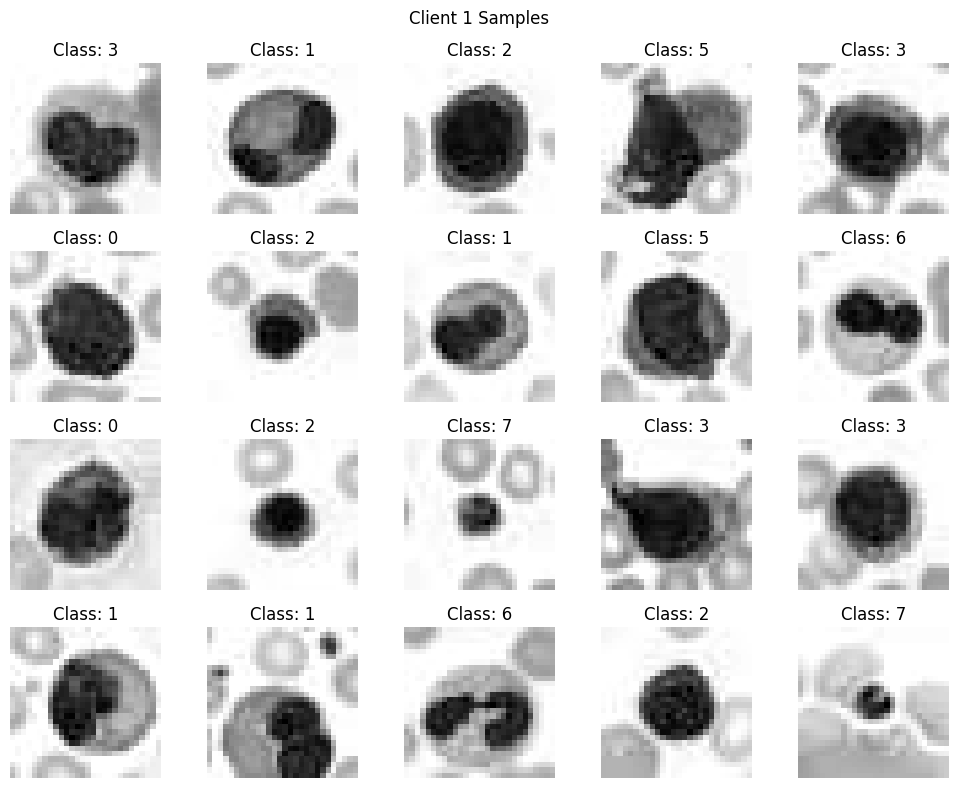

In [52]:
client_id = 0
client_data_loader = train_loaders_iid[client_id]
dataiter = iter(client_data_loader)
images, labels = next(dataiter)

plot_samples(
    (images, labels), 
    channel=0, 
    title=f"Client {client_id+1} Samples", 
    plot_name=f"client_{client_id+1}_samples_iid", 
    n_examples=20
)

3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(64)
        self.relu5 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.relu4(x)
        
        x = self.conv5(x)
        x = self.batch_norm5(x)
        x = self.relu5(x)
        x = self.maxpool2(x)
        
        x = x.view(x.size(0), -1) 
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [57]:
model = CustomCNN(num_classes=8)



### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

In [75]:
final_model, loss_hist, acc_hist = FedProx(
    model=model,
    training_sets=train_loaders_iid,
    testing_sets=test_loaders_iid,
    n_iter=20,  # Number of iterations
    mu=0,  # Given mu value
    epochs=2,  # Number of local epochs
    lr=0.1  # Learning rate
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.222514470418294 Server Test Accuracy: 10.614035087719298
====> i: 1 Loss: 3.3927332560221353 Server Test Accuracy: 19.41520467836257
====> i: 2 Loss: 1.5375186602274575 Server Test Accuracy: 42.485380116959064
====> i: 3 Loss: 1.2353561321894326 Server Test Accuracy: 53.62573099415204
====> i: 4 Loss: 1.1717776854832966 Server Test Accuracy: 63.859649122807014
====> i: 5 Loss: 0.9020177721977234 Server Test Accuracy: 68.18713450292397
====> i: 6 Loss: 0.5129445791244507 Server Test Accuracy: 81.25730994152048
====> i: 7 Loss: 0.9346511165301004 Server Test Accuracy: 66.95906432748538
====> i: 8 Loss: 0.4547051688035329 Server Test Accuracy: 82.046783625731
====> i: 9 Loss: 0.5569049318631489 Server Test Accuracy: 79.21052631578948
====> i: 10 Loss: 0.4174098173777262 Server Test Accuracy: 83.47953216374269
====> i: 11 Loss: 0.44766830404599506 Server Test Accuracy: 81.11111111111111
====> 

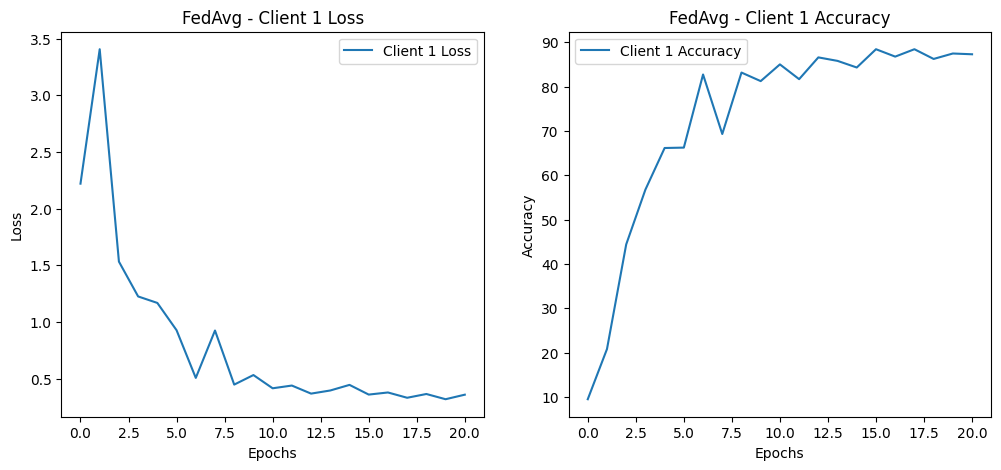

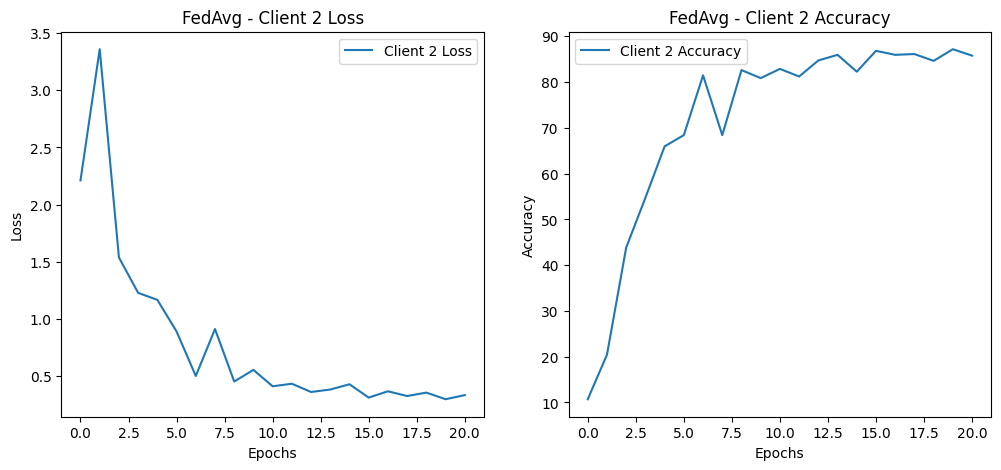

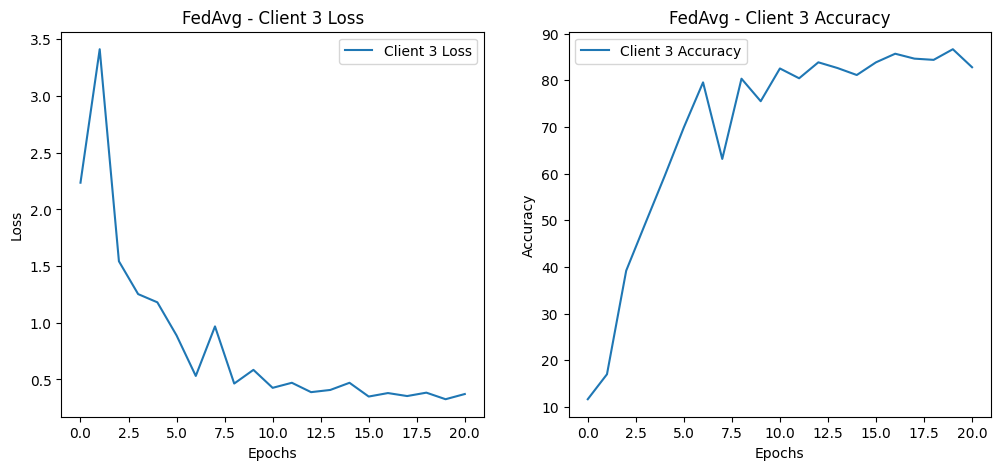

In [76]:
plot_accuracy_loss("FedAvg", loss_hist, acc_hist)

### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

In [77]:
final_model, loss_hist, acc_hist = FedProx(
    model=model,
    training_sets=train_loaders_iid,
    testing_sets=test_loaders_iid,
    n_iter=20,  # Number of iterations
    mu=0.3,  # Given mu value
    epochs=2,  # Number of local epochs
    lr=0.1  # Learning rate
)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.216667890548706 Server Test Accuracy: 10.23391812865497
====> i: 1 Loss: 2.1134548981984453 Server Test Accuracy: 14.824561403508772
====> i: 2 Loss: 1.0073415239651997 Server Test Accuracy: 62.57309941520468
====> i: 3 Loss: 0.6928262710571289 Server Test Accuracy: 71.52046783625731
====> i: 4 Loss: 0.5874251127243042 Server Test Accuracy: 76.57894736842104
====> i: 5 Loss: 1.6270352999369302 Server Test Accuracy: 51.87134502923976
====> i: 6 Loss: 0.47494083642959595 Server Test Accuracy: 82.60233918128655
====> i: 7 Loss: 0.3942152659098307 Server Test Accuracy: 85.08771929824562
====> i: 8 Loss: 0.598186691602071 Server Test Accuracy: 79.32748538011695
====> i: 9 Loss: 0.6680628856023152 Server Test Accuracy: 75.67251461988303
====> i: 10 Loss: 0.5349350372950236 Server Test Accuracy: 79.88304093567251
====> i: 11 Loss: 0.6189653476079304 Server Test Accuracy: 77.42690058479532
====> i

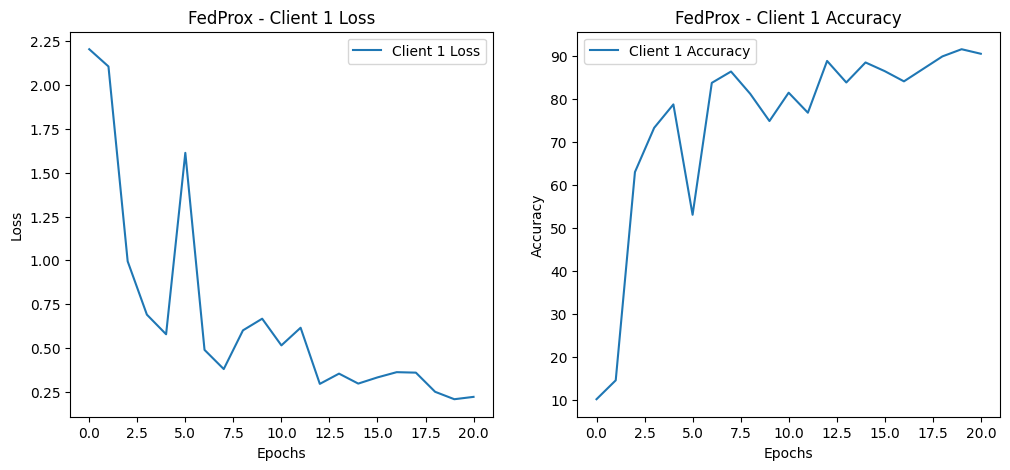

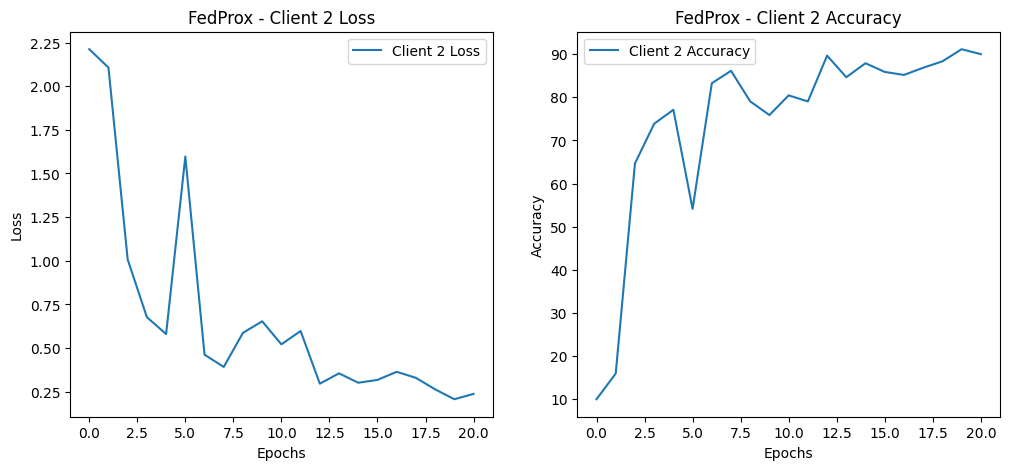

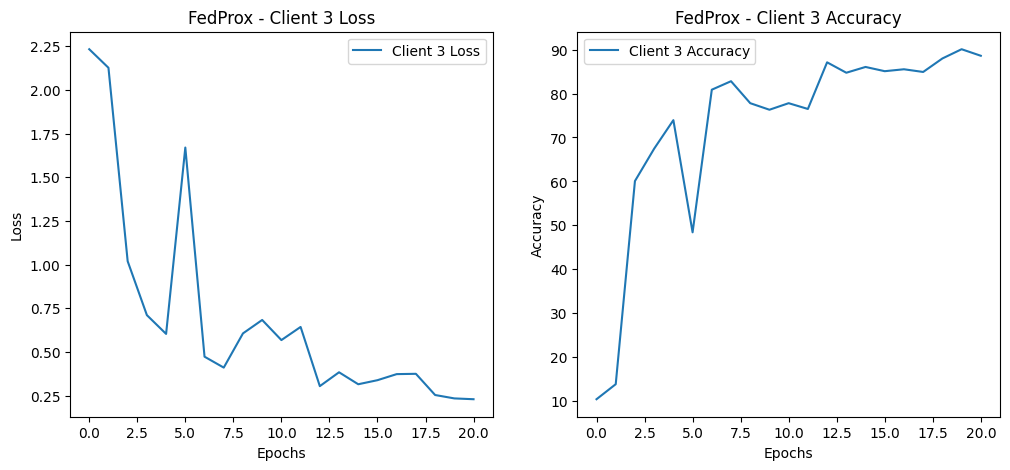

In [78]:
plot_accuracy_loss("FedProx", loss_hist, acc_hist)

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

In [79]:
train_loaders_non_iid, test_loaders_non_iid = get_BloodMNIST(
    type="non_iid", 
    n_samples_train=200, 
    n_samples_test=100, 
    n_clients=3, 
    batch_size=128, 
    shuffle=True
)

In [85]:
final_model, loss_hist, acc_hist = FedProx(
    model=model,
    training_sets=train_loaders_non_iid,
    testing_sets=test_loaders_non_iid,
    n_iter=20,  # Number of iterations
    mu=0,  # Given mu value
    epochs=2,  # Number of local epochs
    lr=0.1  # Learning rate
)

Clients' weights: [0.31833333333333336, 0.3333333333333333, 0.34833333333333333]
====> i: 0 Loss: 2.2291303392251334 Server Test Accuracy: 11.22822109083577
====> i: 1 Loss: 87.65784530162811 Server Test Accuracy: 18.848547400611622
====> i: 2 Loss: 2.2093613843123117 Server Test Accuracy: 7.148472964344524
====> i: 3 Loss: 2.098155805269877 Server Test Accuracy: 15.201501831501833
====> i: 4 Loss: 2.0295388253529865 Server Test Accuracy: 21.02867442954599
====> i: 5 Loss: 1.9861255596081415 Server Test Accuracy: 23.357895957253756
====> i: 6 Loss: 1.9347171099980673 Server Test Accuracy: 23.625688745505258
====> i: 7 Loss: 1.9948506361246108 Server Test Accuracy: 21.370443425076452
====> i: 8 Loss: 1.7778854032357534 Server Test Accuracy: 32.28385388311994
====> i: 9 Loss: 1.7018505422274273 Server Test Accuracy: 38.61989296636086
====> i: 10 Loss: 1.5655270894368492 Server Test Accuracy: 39.565081157374735
====> i: 11 Loss: 1.5328567060828209 Server Test Accuracy: 44.36351681957187
=

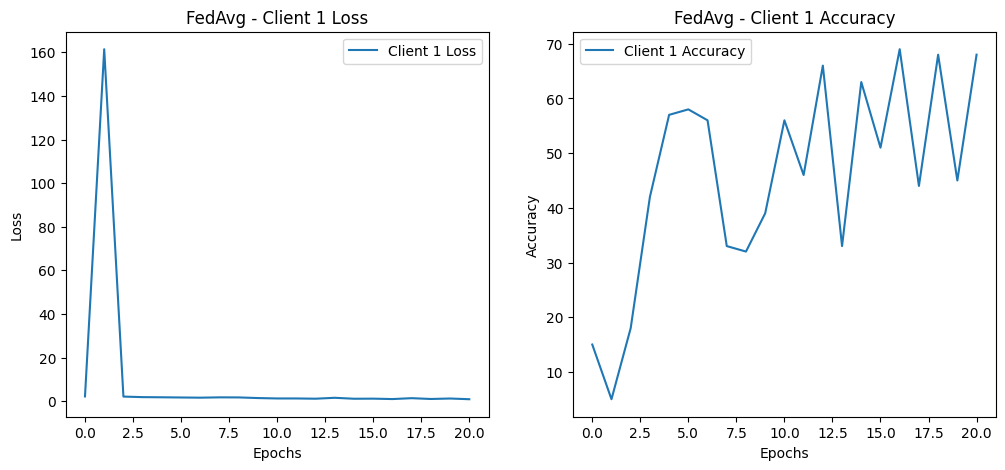

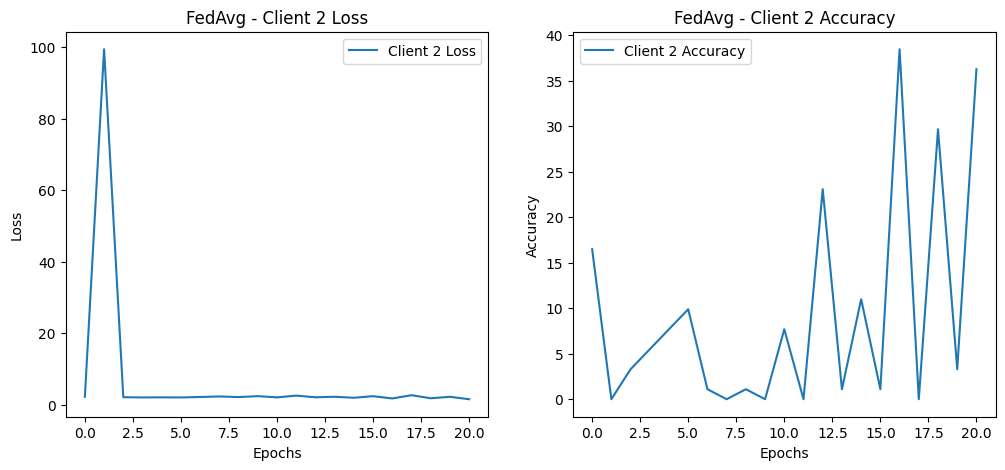

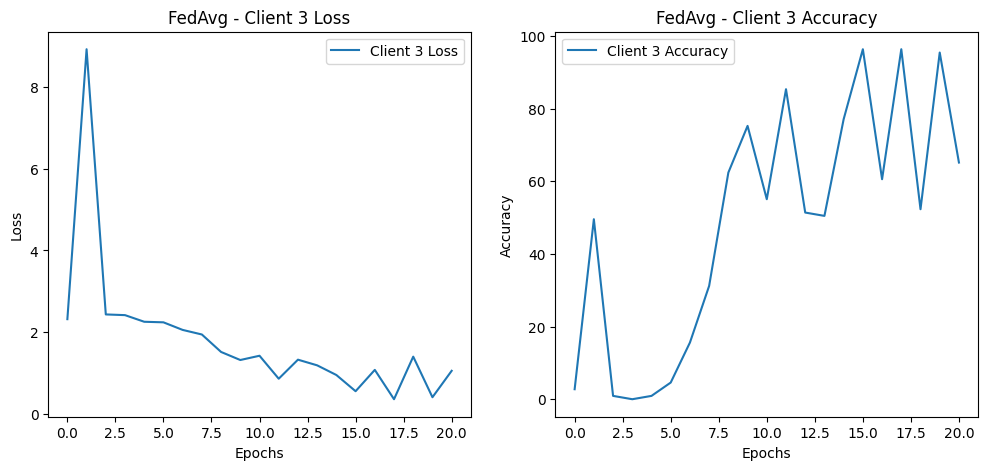

In [86]:
plot_accuracy_loss("FedAvg", loss_hist, acc_hist)

In [87]:
final_model, loss_hist, acc_hist = FedProx(
    model=model,
    training_sets=train_loaders_non_iid,
    testing_sets=test_loaders_non_iid,
    n_iter=10,  # Number of iterations
    mu=0.3,  # Given mu value
    epochs=2,  # Number of local epochs
    lr=0.1  # Learning rate
)

Clients' weights: [0.31833333333333336, 0.3333333333333333, 0.34833333333333333]
====> i: 0 Loss: 2.2303619110584263 Server Test Accuracy: 12.915821823436502
====> i: 1 Loss: 14.83941270192464 Server Test Accuracy: 20.13302752293578
====> i: 2 Loss: 2.071632641951243 Server Test Accuracy: 15.641681957186544
====> i: 3 Loss: 2.054041086832682 Server Test Accuracy: 20.176040427462446
====> i: 4 Loss: 2.045553753376007 Server Test Accuracy: 20.54605639009309
====> i: 5 Loss: 2.0327496596177417 Server Test Accuracy: 19.54061229290587
====> i: 6 Loss: 2.032801967461904 Server Test Accuracy: 21.19148922942501
====> i: 7 Loss: 2.0095231499274573 Server Test Accuracy: 18.230651611385554
====> i: 8 Loss: 1.9837043927113216 Server Test Accuracy: 20.981668178915882
====> i: 9 Loss: 1.9625684253374736 Server Test Accuracy: 20.893358201431596
====> i: 10 Loss: 1.8149249299367267 Server Test Accuracy: 35.22221662129919


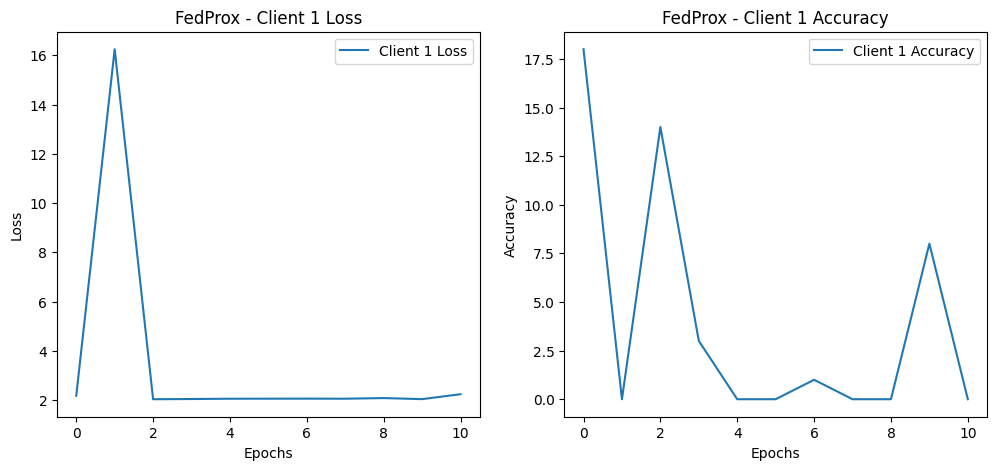

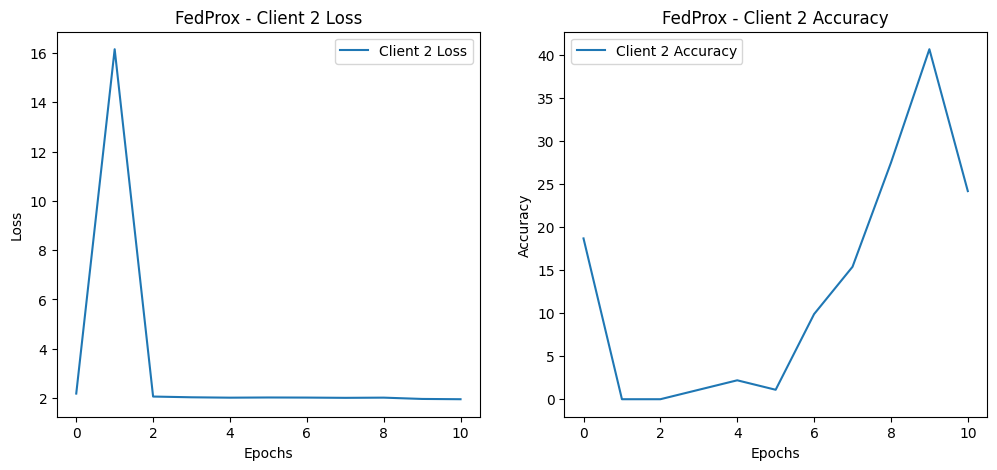

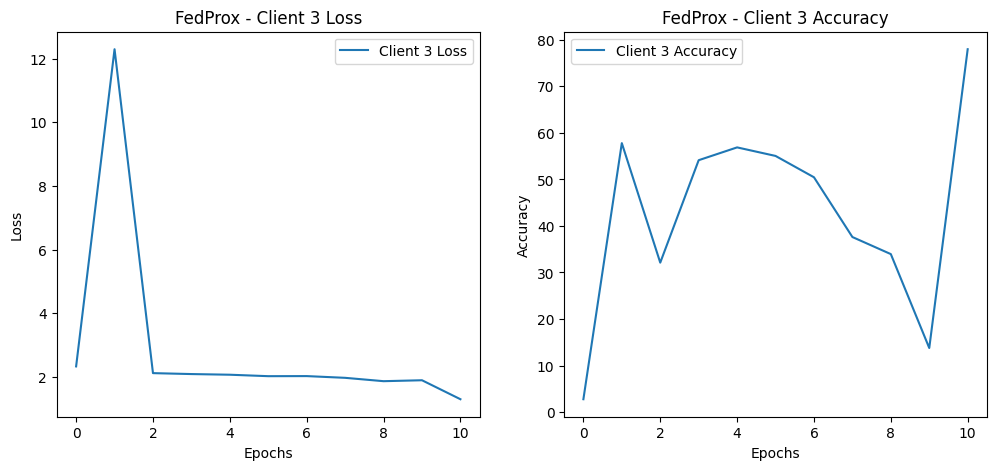

In [88]:
plot_accuracy_loss("FedProx", loss_hist, acc_hist)

7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf

On peut améliorer les résultats avec les méthodes suivantes : 

- Utilisation de Learning Rate Scheduling:

Ajustez le taux d'apprentissage pendant l'entraînement. Commencez par un taux d'apprentissage élevé et diminuez-le progressivement au fur et à mesure que l'entraînement progresse.

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)